In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from math import log
from CIoTS import *
import json
from time import time
import random
from copy import deepcopy

In [6]:
def simulate_patience(iterations, patience=1):
    no_imp = 0
    current_min = 0
    time = iterations[0]['time']
    for current, iteration in enumerate(iterations):
        if current == 0:
            continue
        no_imp += 1
        time += iteration['time']
        if iteration['bic'] < iterations[current_min]['bic']:
            current_min = current
            no_imp = 0
        if no_imp >= patience:
            break
    result_iteration = deepcopy(iterations[current_min])
    result_iteration['cumulated_time'] = time
    result_iteration['p_est'] = result_iteration['p_iter']
    return result_iteration

In [7]:
def simulate_peaks(estimates, peaks):
    result_estimate = {}
    for estimate in estimates:
        if estimates['peaks'] == peaks:
            result_estimate = deepcopy(estimate)
    return estimate

In [8]:
def select_experiments(setting, results):
    result_experiments = []
    for res in results:
        check = True
        for key, value in setting.items():
            if key not in res or res[key] != value:
                check = False
        if check:
            result_experiments = deepcopy(res['experiments'])
    return result_experiments

In [9]:
patience = 1
peaks = 1
dimensions = 3
p_range = [5, 10, 15, 20]
in_edges = 2

result_dir = 'results/p_estimation/'

In [10]:
with open(result_dir+'estimates_pc1.json', 'r') as f:
    results_pc1 = json.load(f)
    
#with open(result_dir+'estimates_cross_corr.json', 'r') as f:
#    results_cross_corr = json.load(f)
    
with open(result_dir+'estimates_var_pre2.json', 'r') as f:
    results_var = json.load(f)

In [148]:
pc1_means = []
pc1_stdev = []
pc1_medians = []

var_means = []
var_stdev = []
var_medians = []

cross_corr_means = []
cross_corr_stdev = []
cross_corr_medians = []

for p in p_range:
    setting = {'dim': dimensions, 'in_edges': in_edges, 'p': p}
    
    pc1_est = [simulate_patience(exp['iterations'], patience)['p_est']
               for exp in select_experiments(setting, results_pc1)]
    pc1_means.append(np.mean(pc1_est))
    pc1_stdev.append(np.std(pc1_est))
    pc1_medians.append(np.median(pc1_est))
    
    continue
    var_est = [exp['estimates'][0]['p_est']
               for exp in select_experiments(setting, results_var)]
    var_means.append(np.mean(var_est))
    var_stdev.append(np.std(var_est))
    var_medians.append(np.median(var_est))
    
    cross_corr_est = [simulate_peaks(exp['estimates'], peaks)['p_est']
                      for exp in select_experiments(setting, results_cross_corr)]
    cross_corr_means.append(np.mean(cross_corr_est))
    cross_corr_stdev.append(np.std(cross_corr_est))
    cross_corr_medians.append(np.median(cross_corr_est))

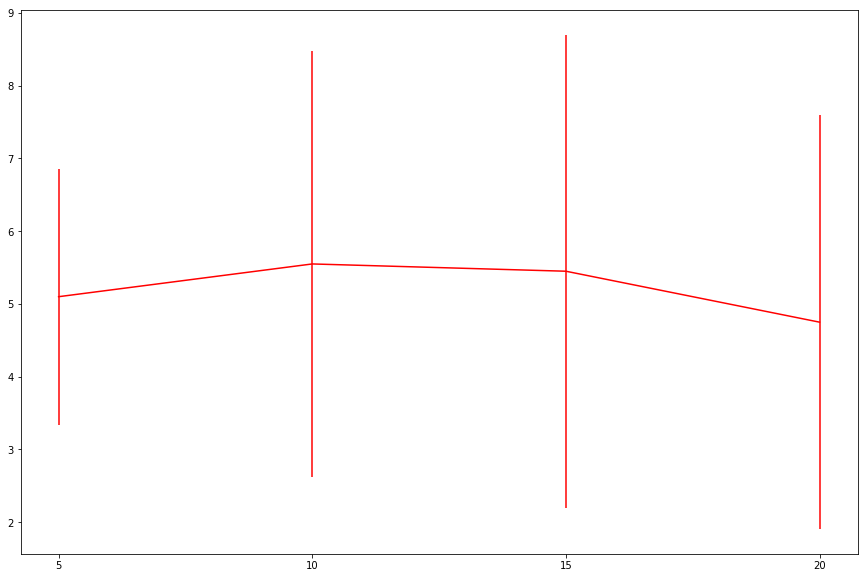

In [150]:
plt.figure(figsize=(15, 10))
plt.errorbar(x=p_range, y=pc1_means, yerr=pc1_stdev, c='r')
#plt.errorbar(x=p_range, y=var_means, yerr=var_stdev, c='b')
plt.xticks(p_range, p_range)
plt.show()

In [103]:
pc1_means

[5.15, 6.05, 6.2, 4.8]

In [104]:
pc1_stdev

[1.8781639970992947, 3.169779172119093, 2.6, 2.4]

In [105]:
pc1_medians

[5.0, 5.5, 6.0, 4.0]

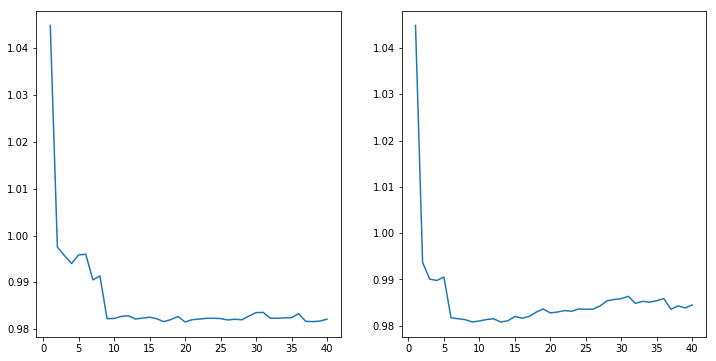

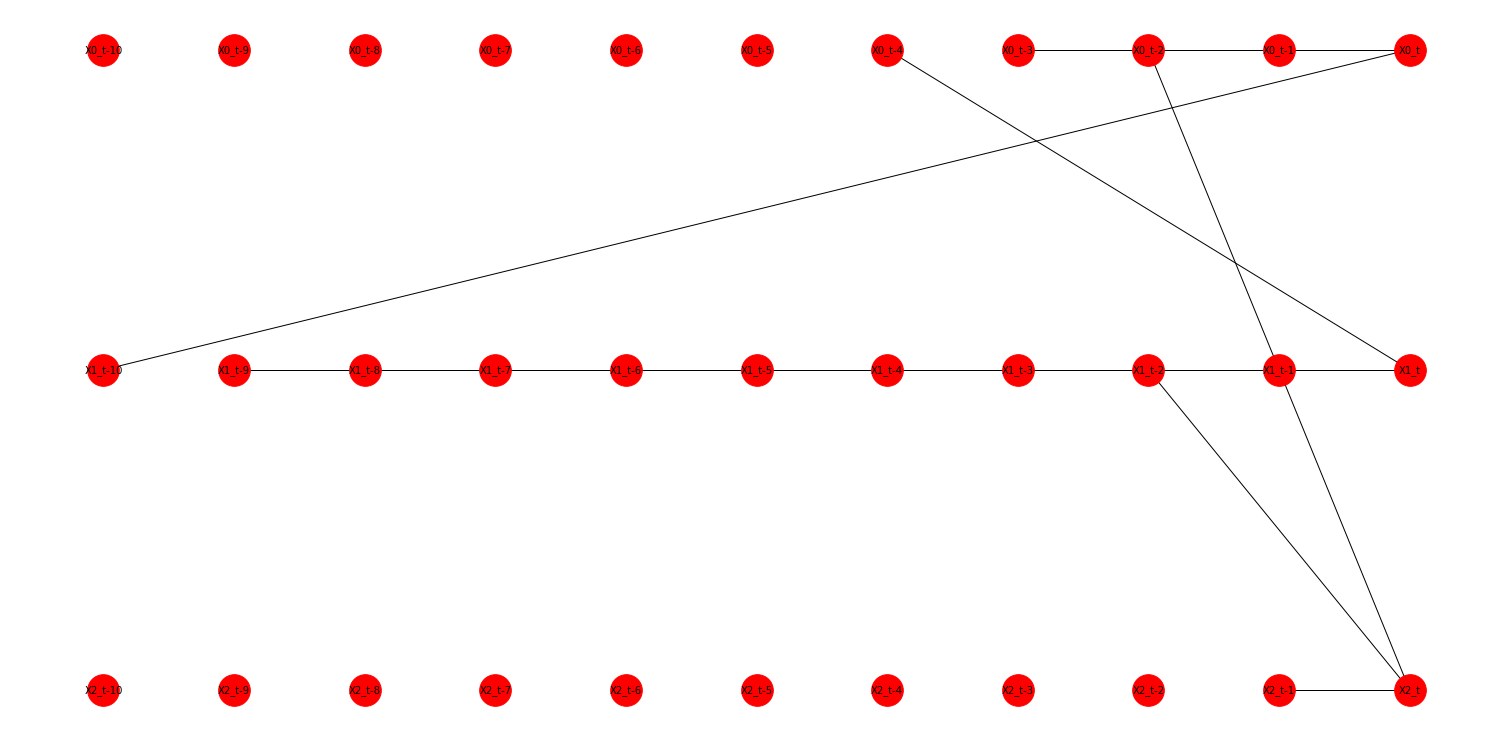

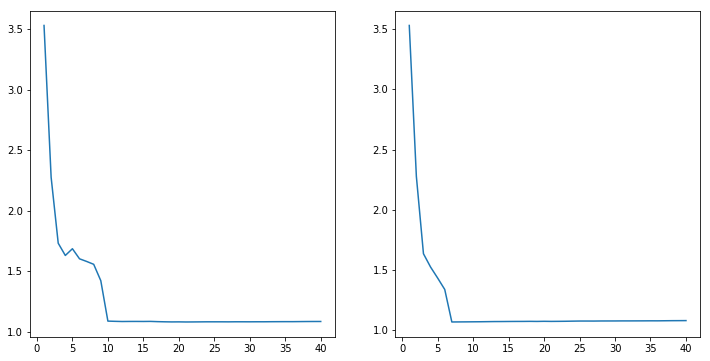

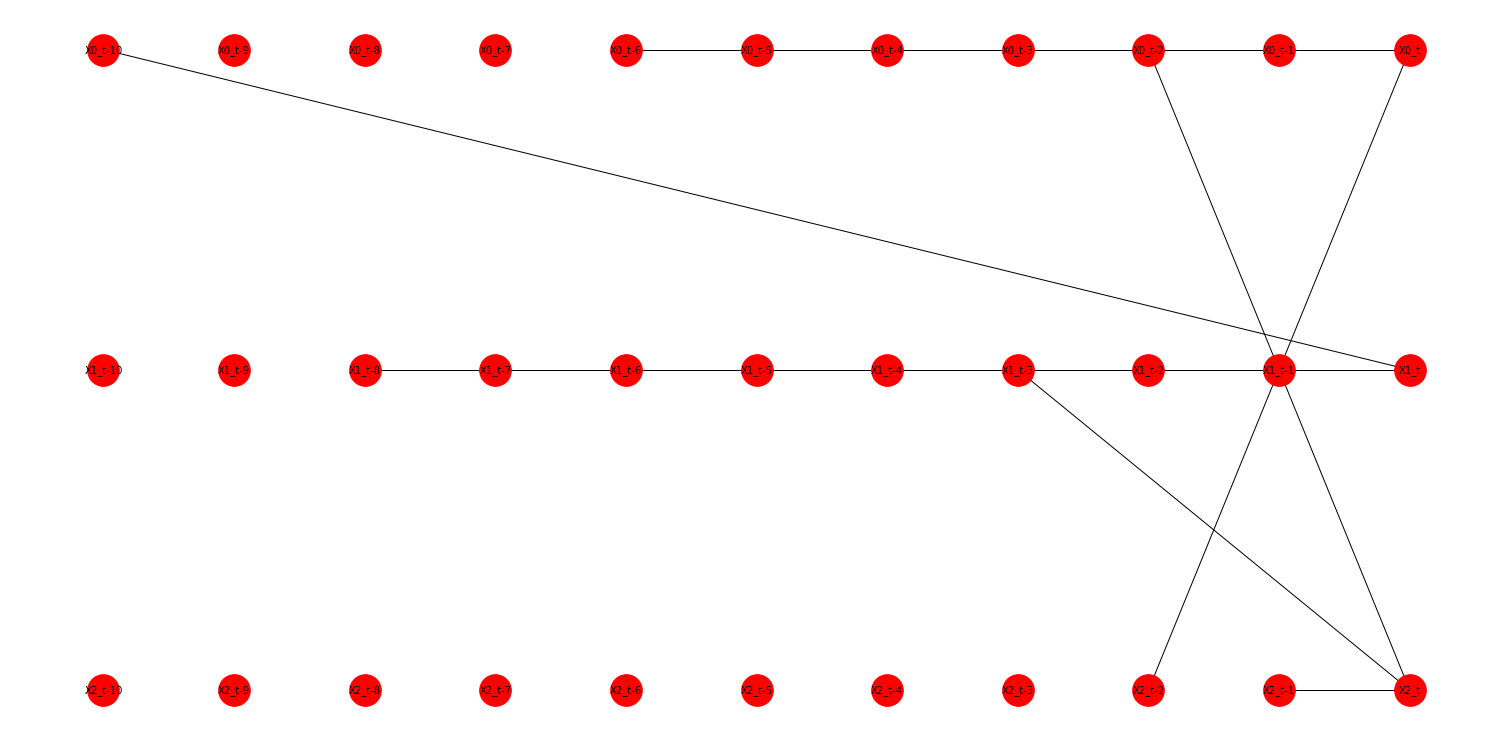

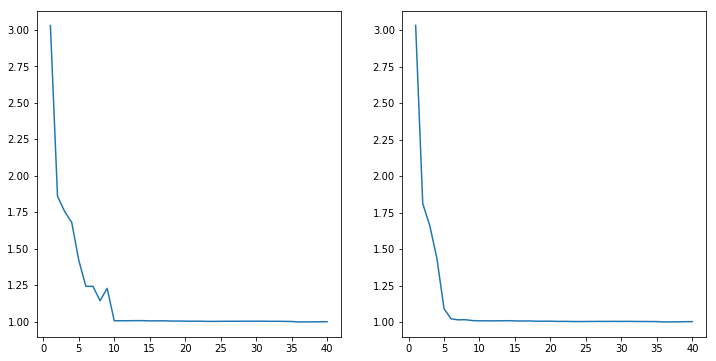

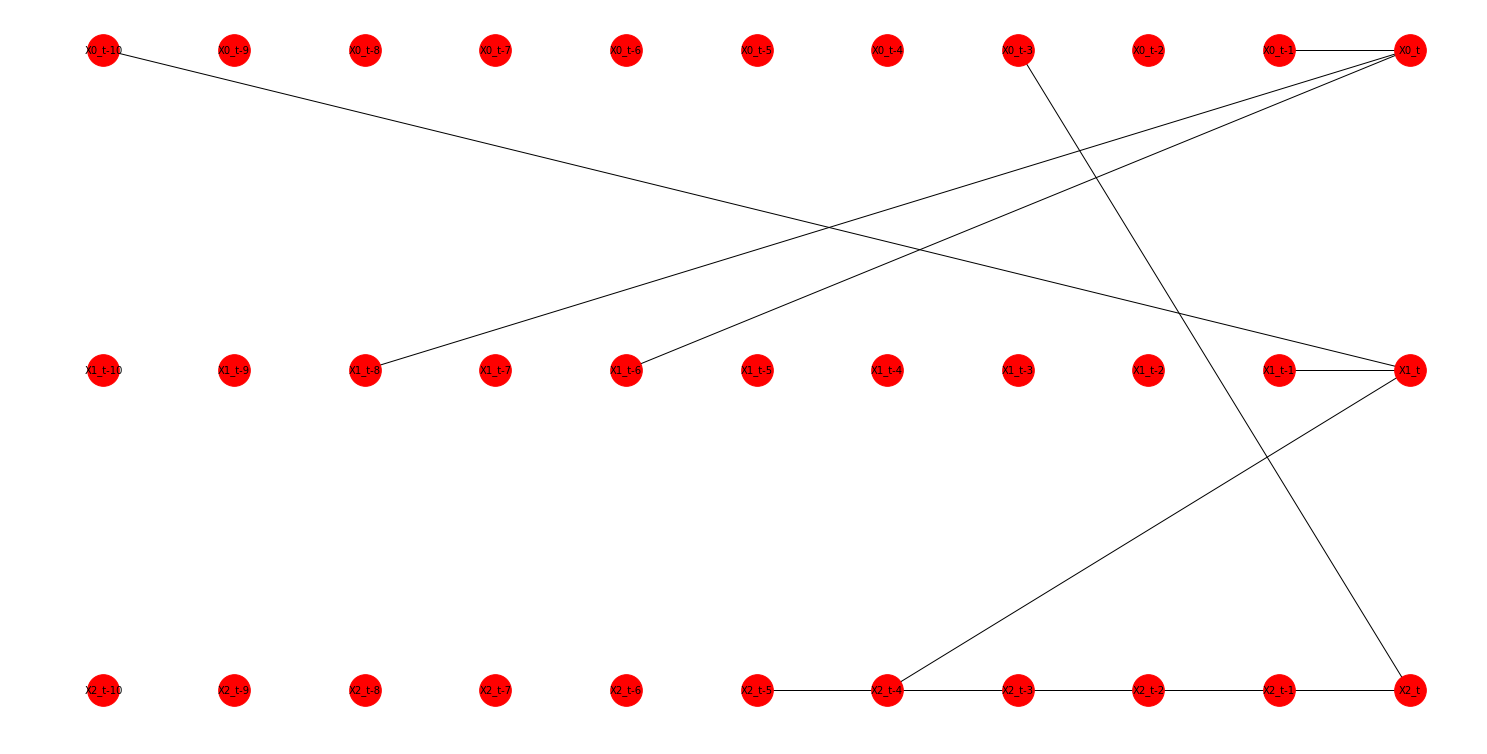

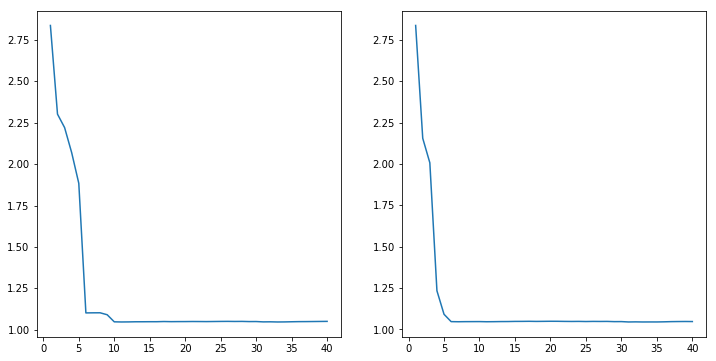

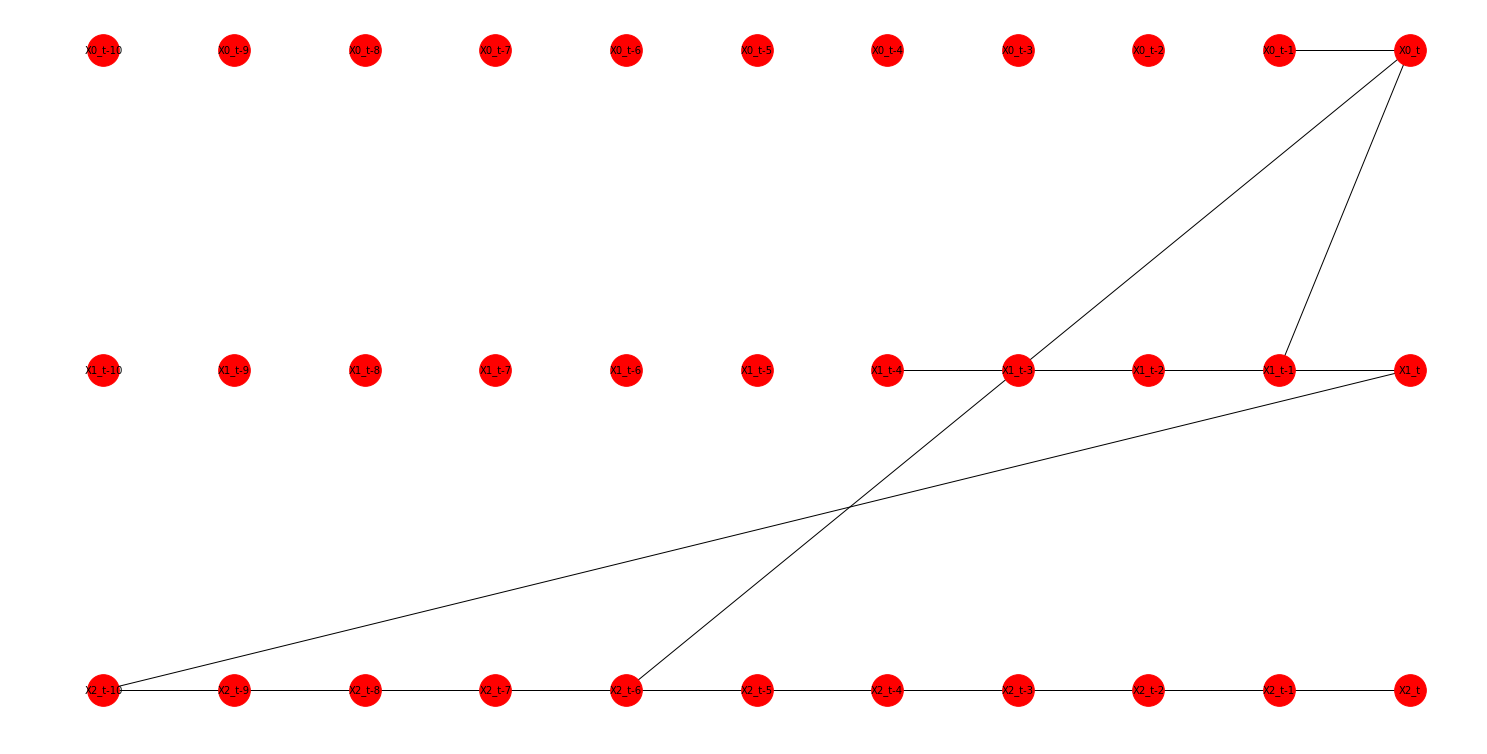

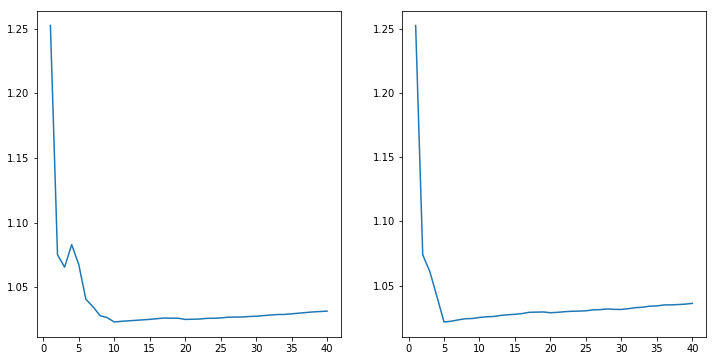

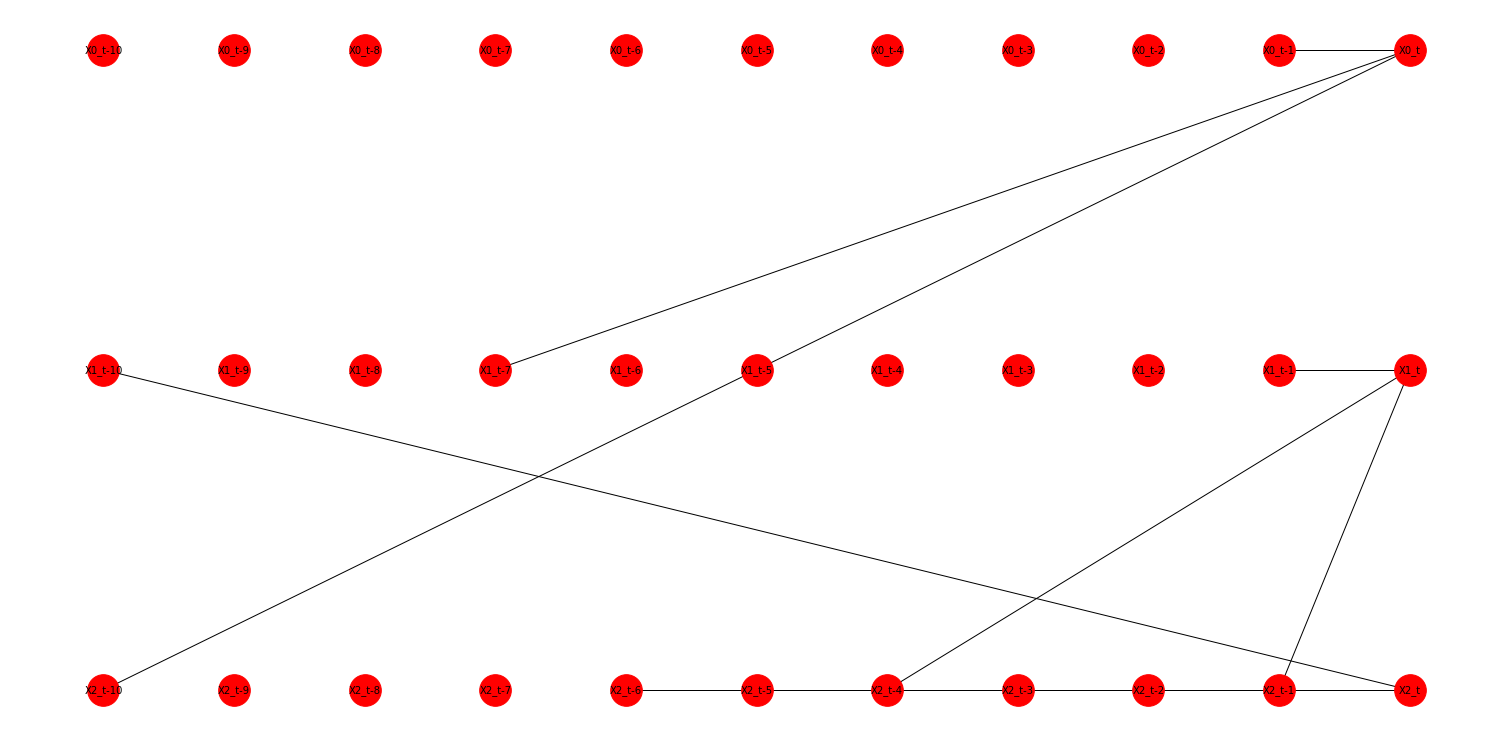

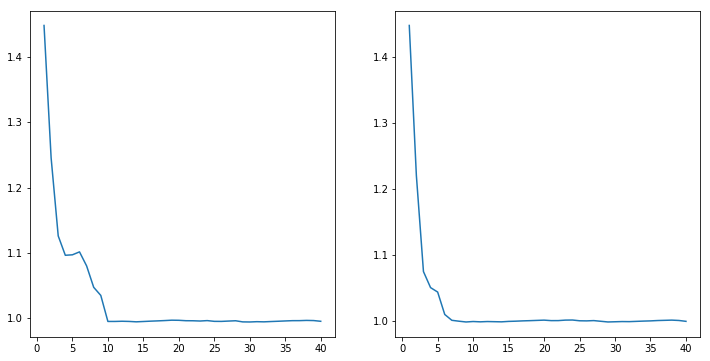

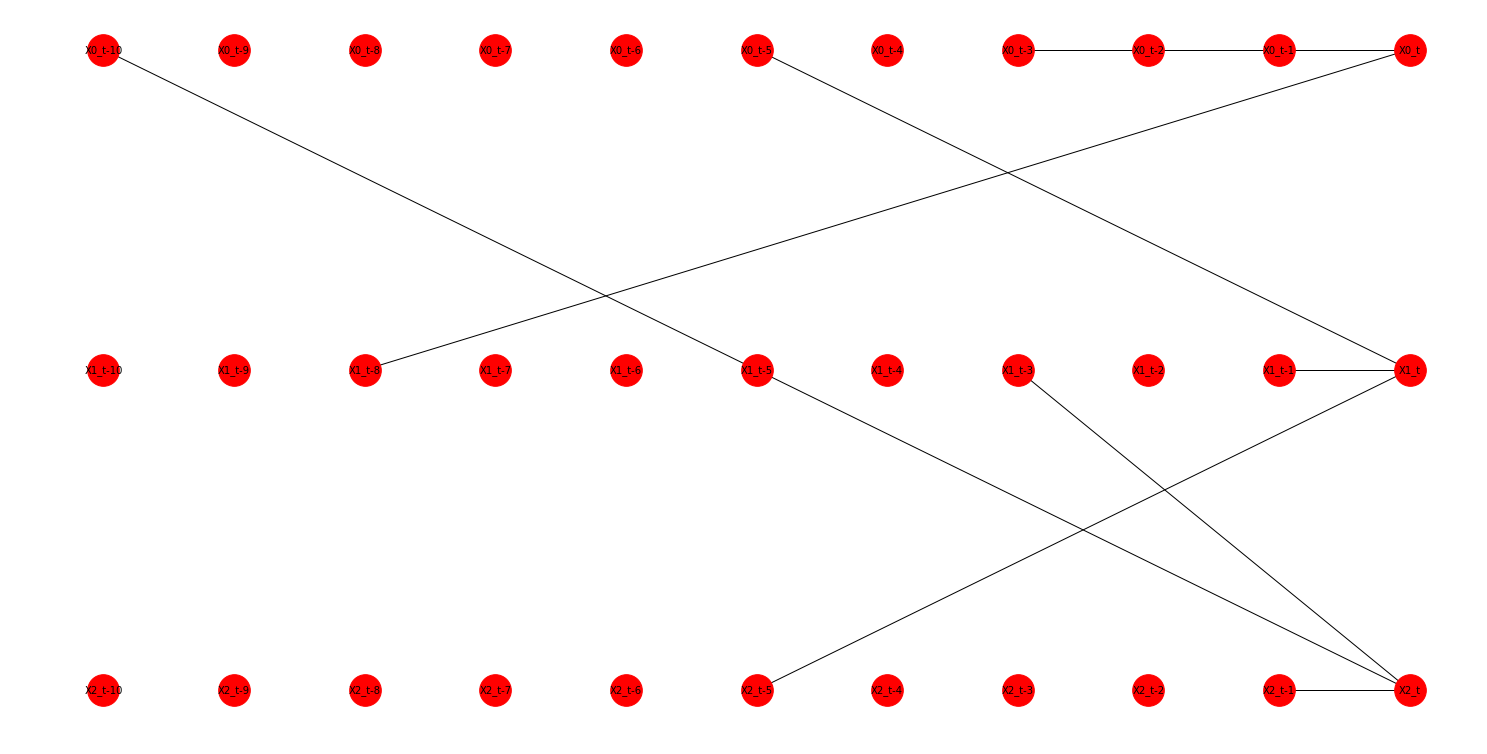

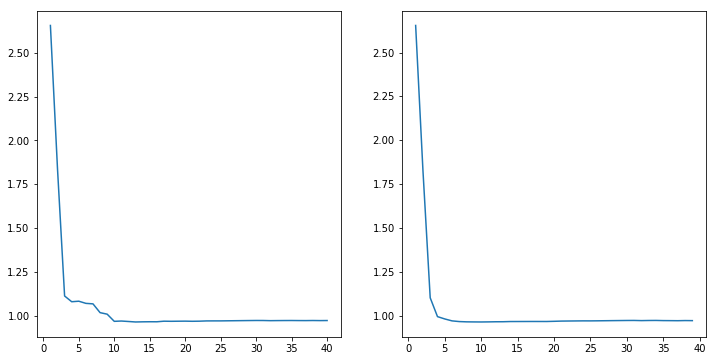

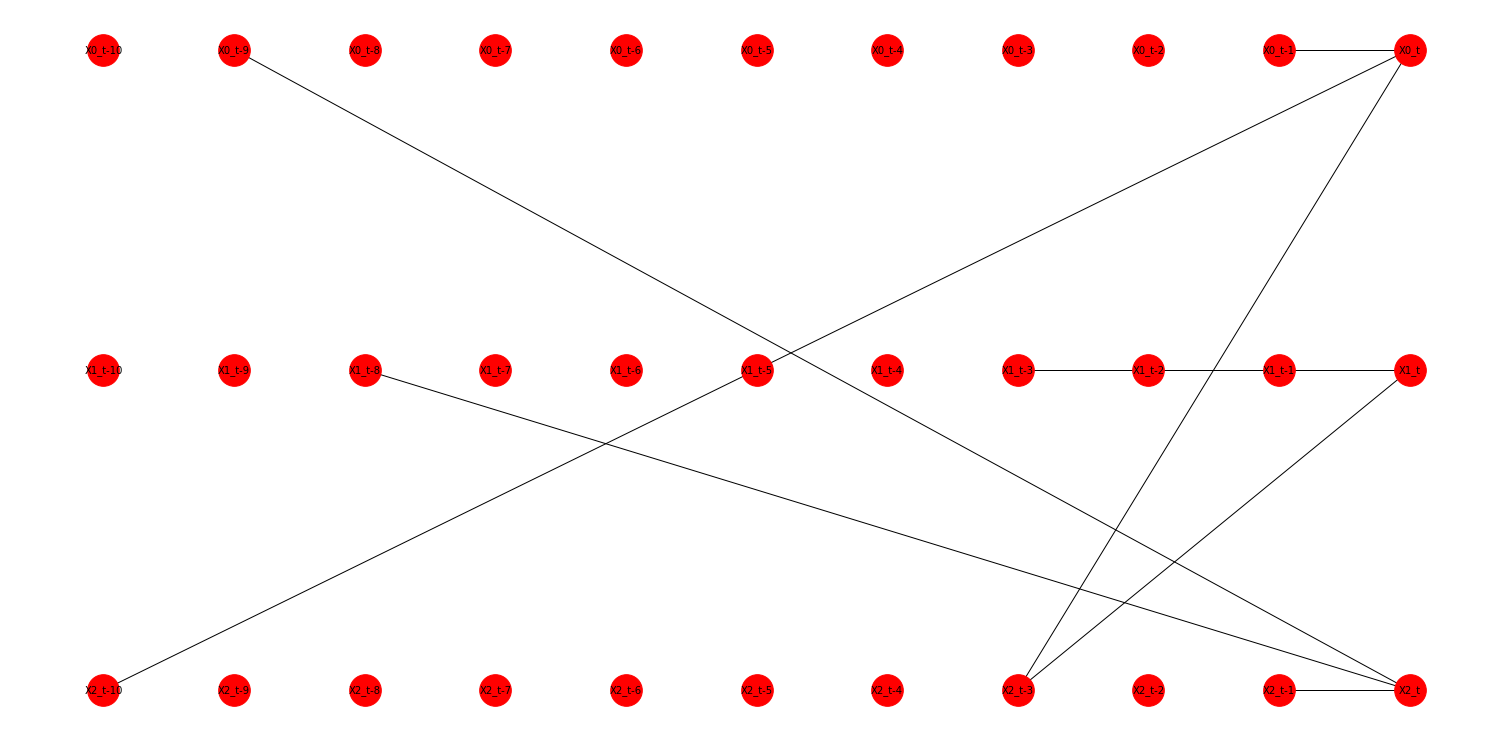

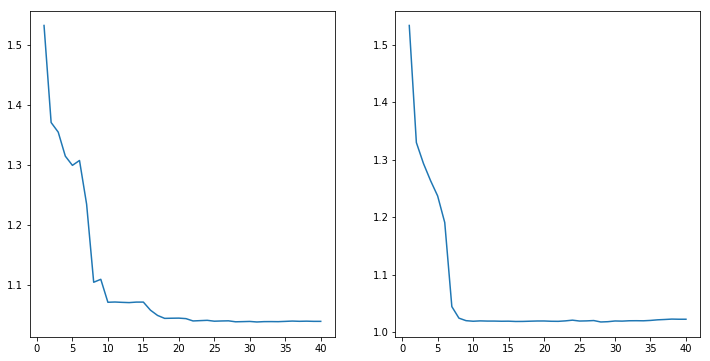

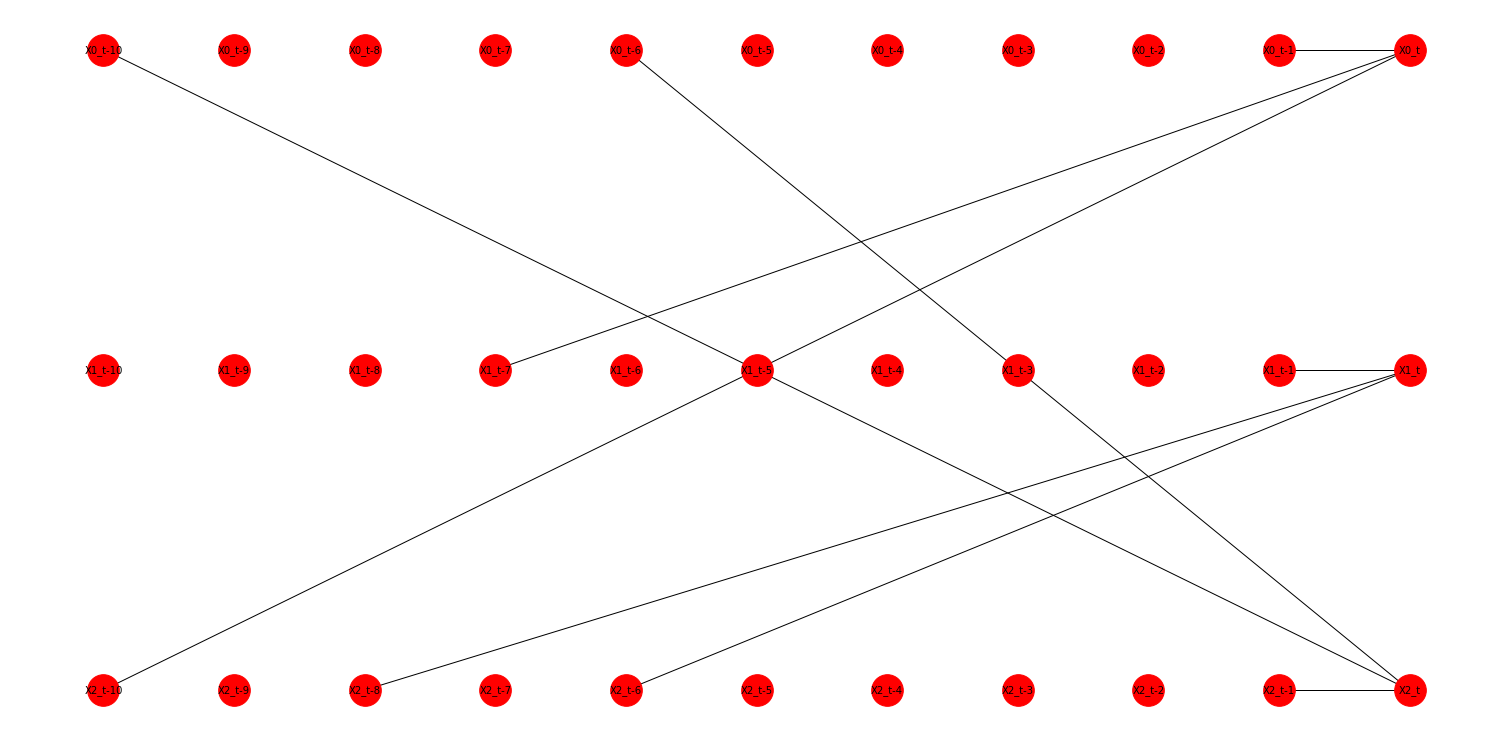

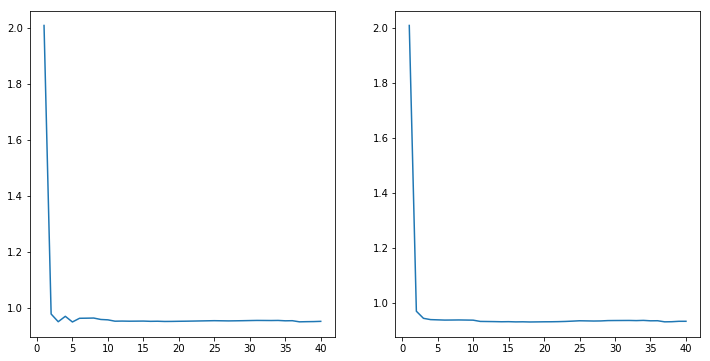

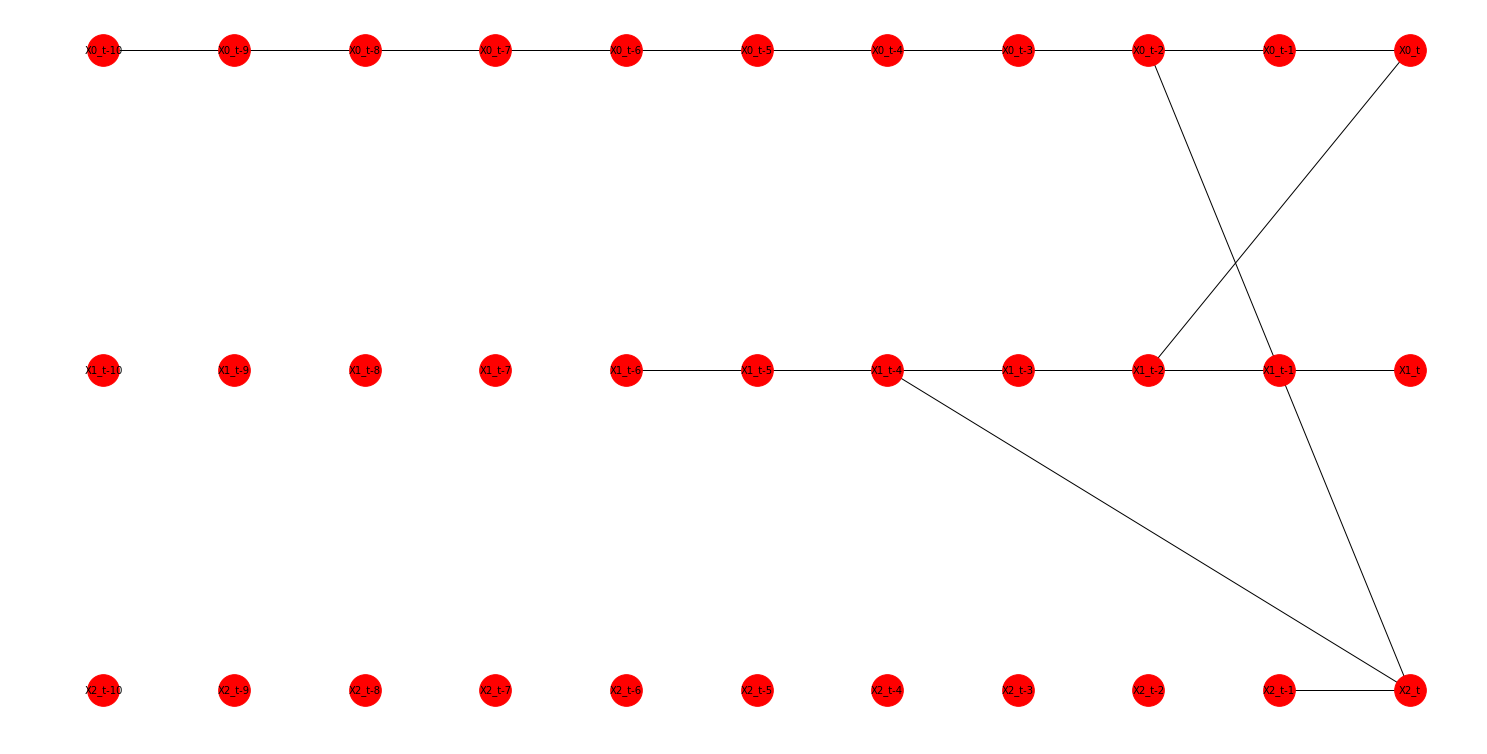

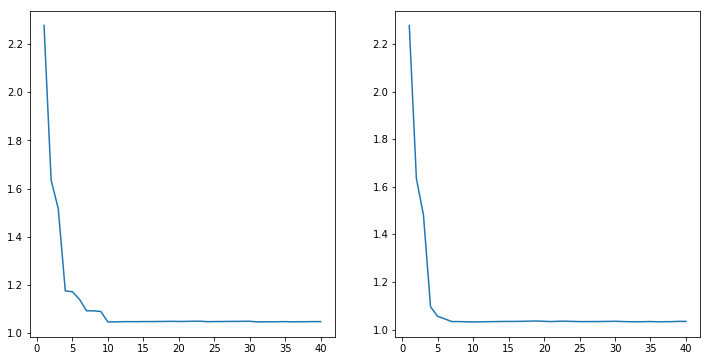

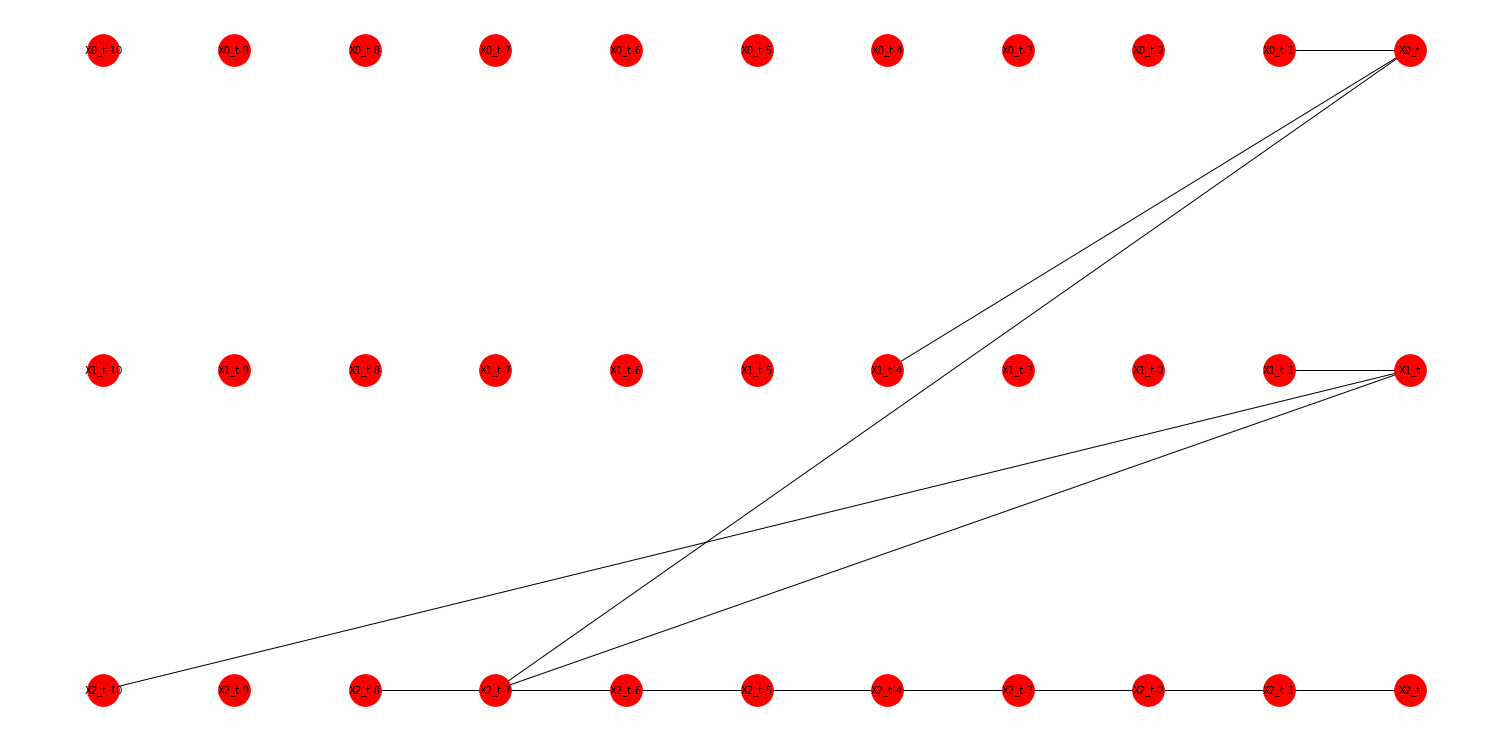

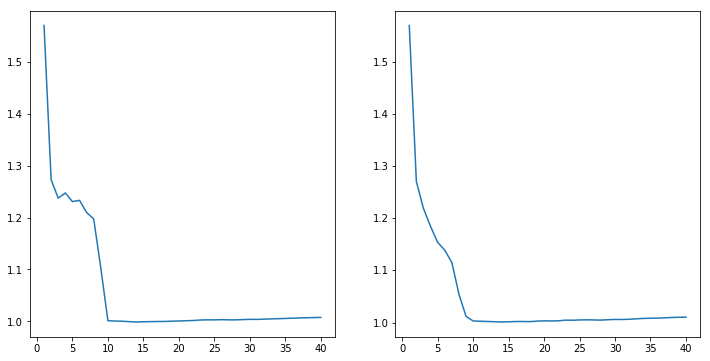

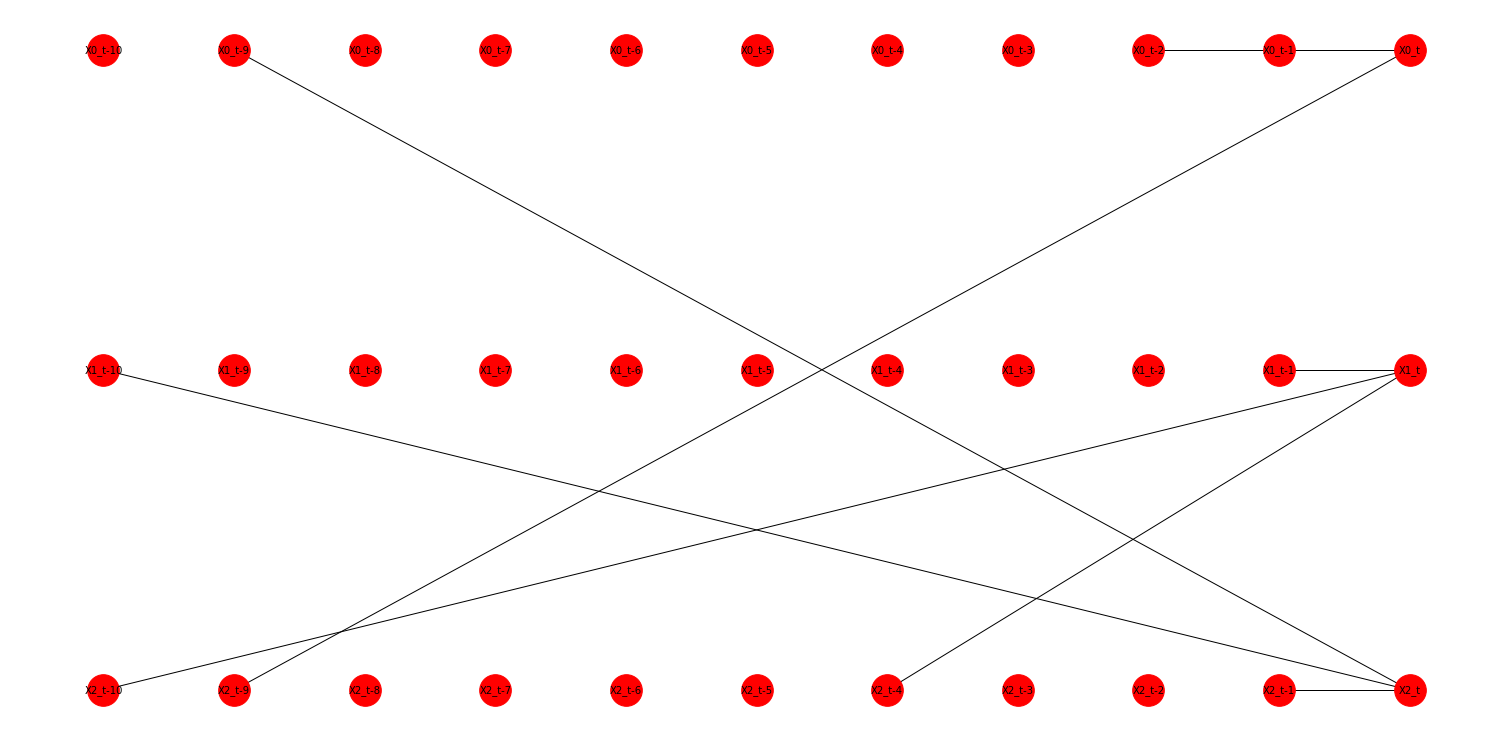

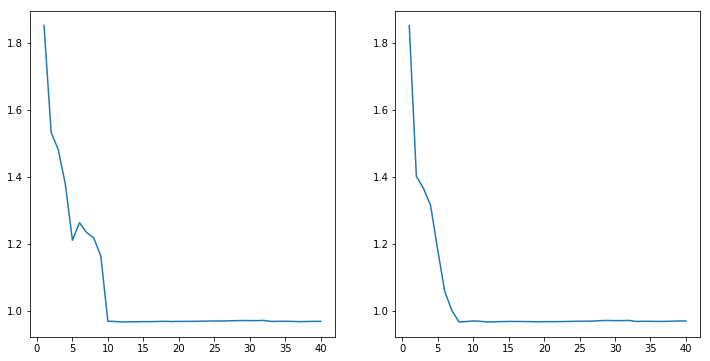

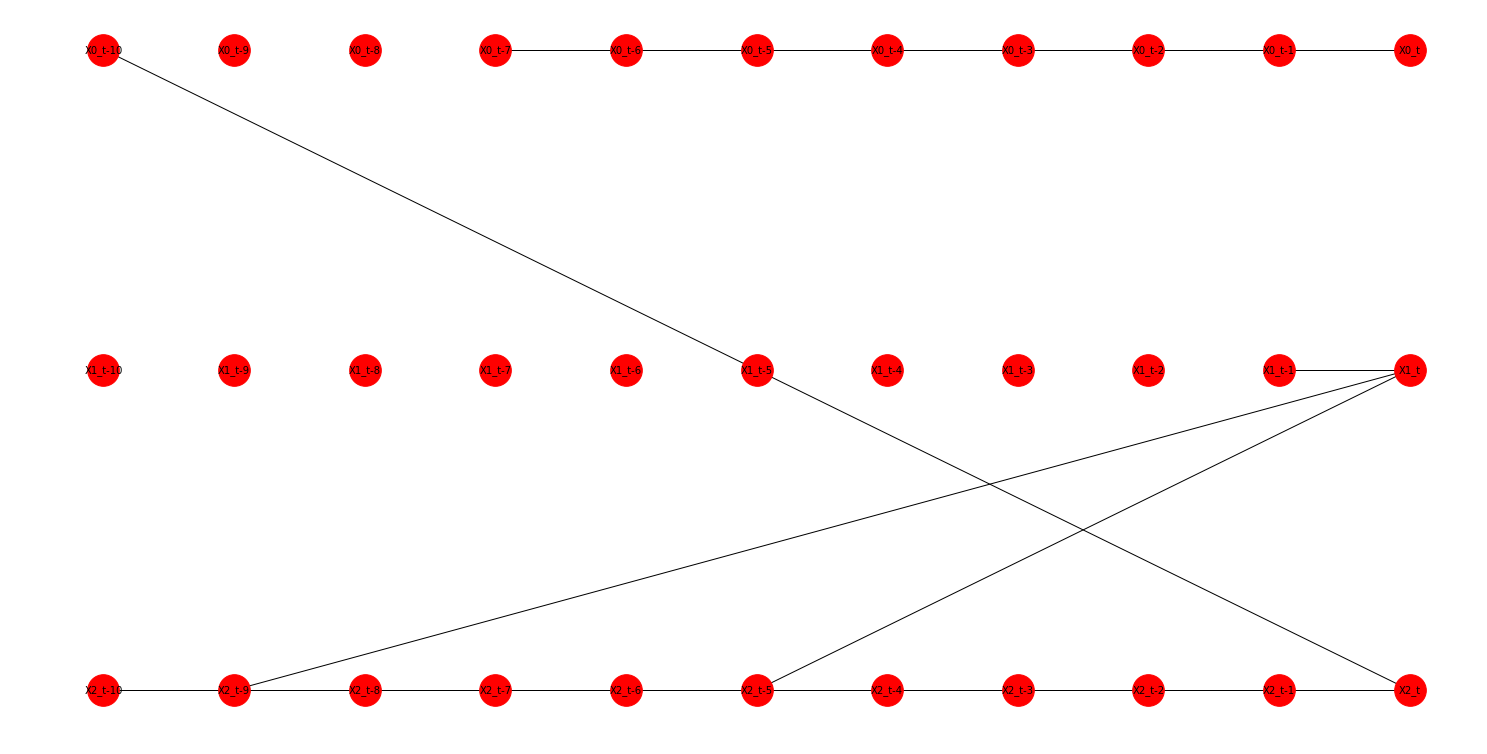

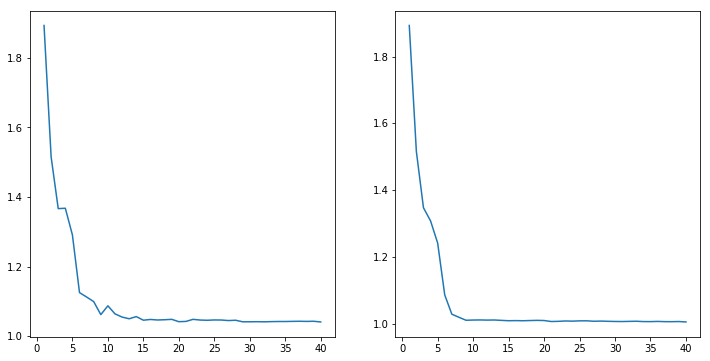

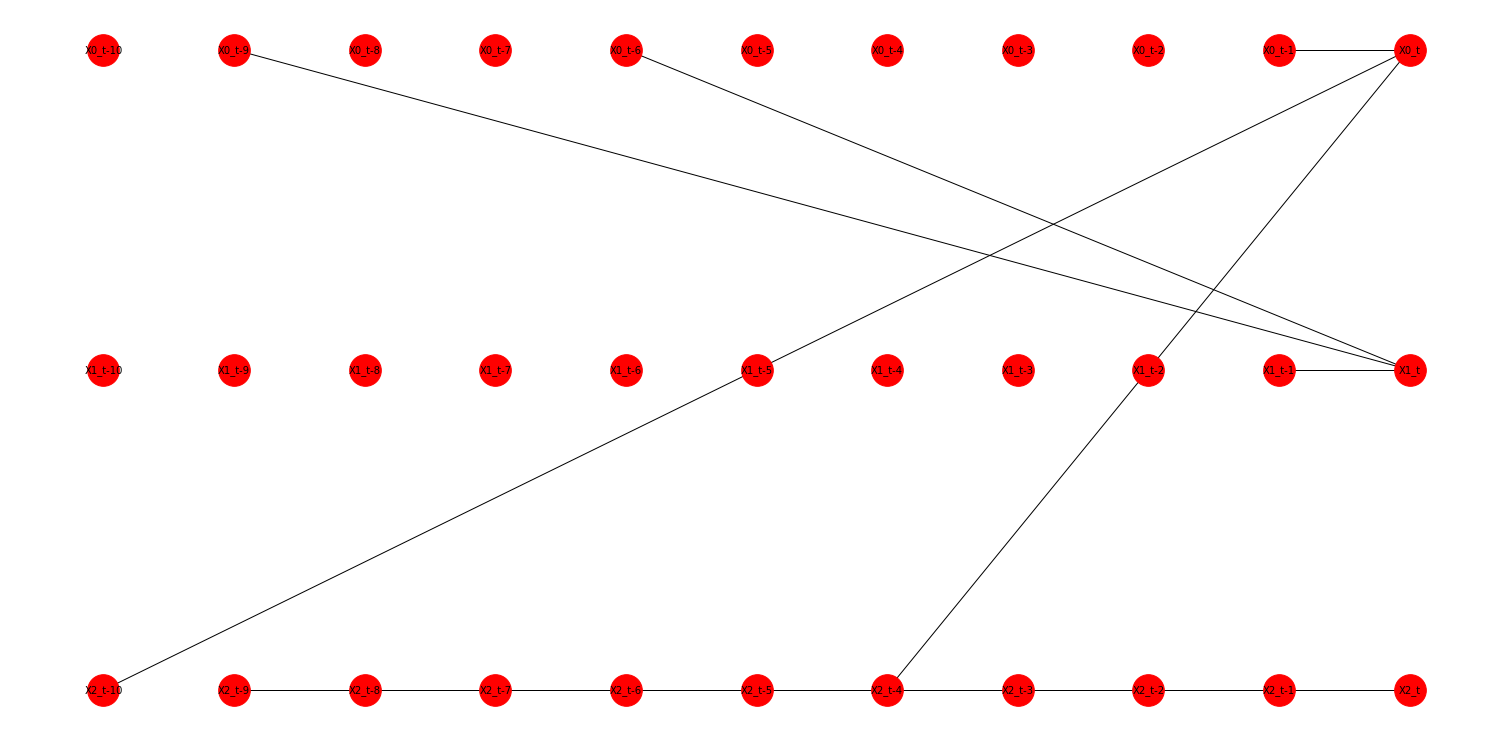

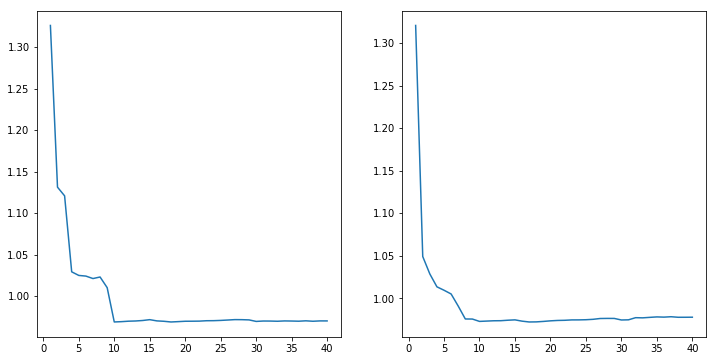

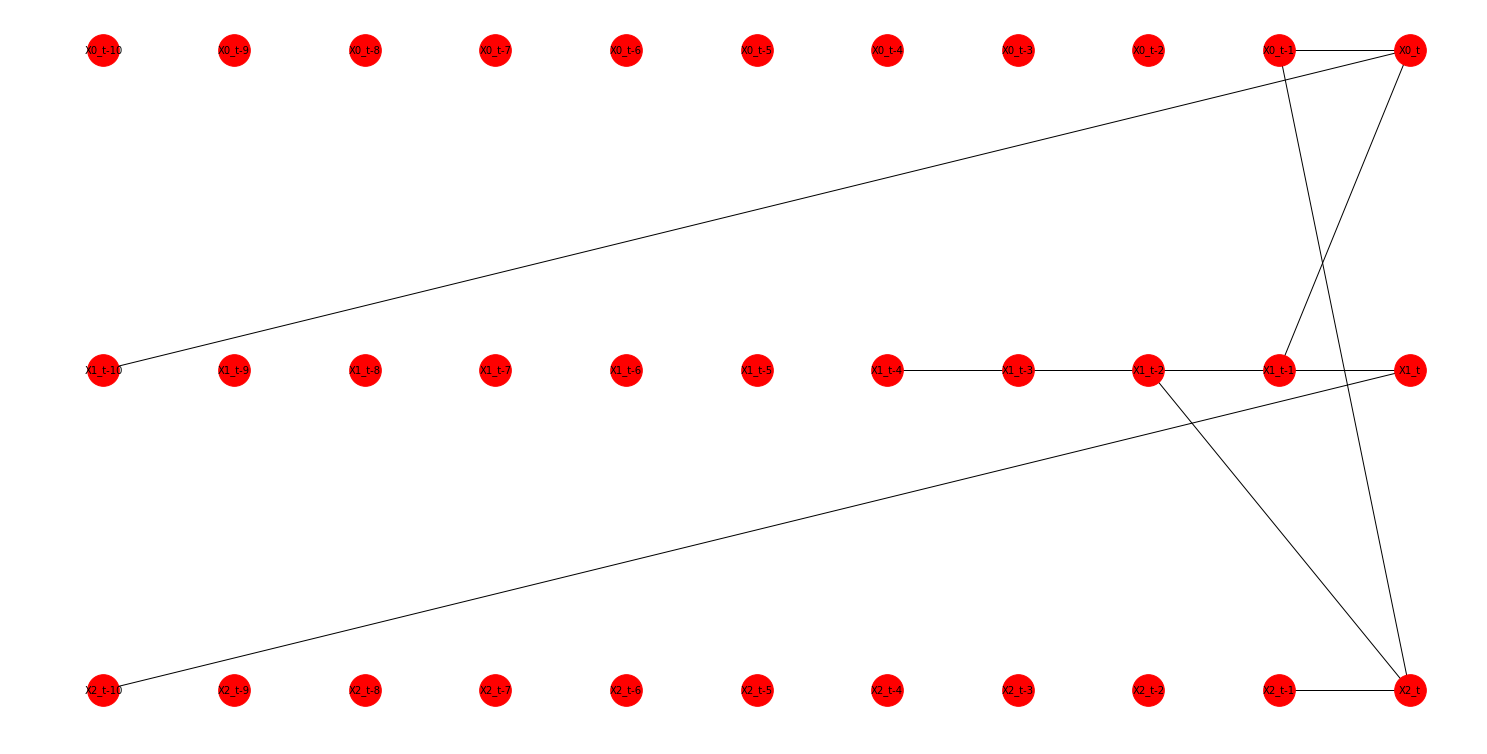

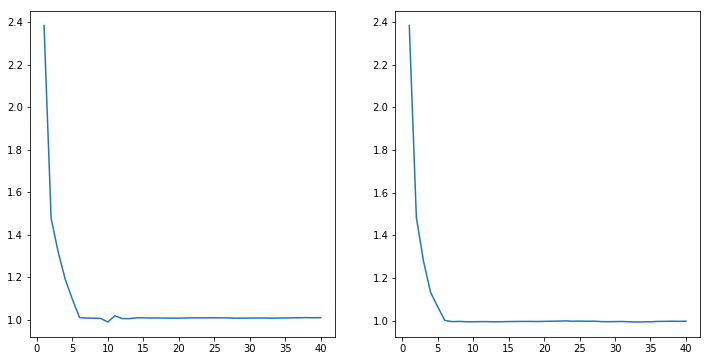

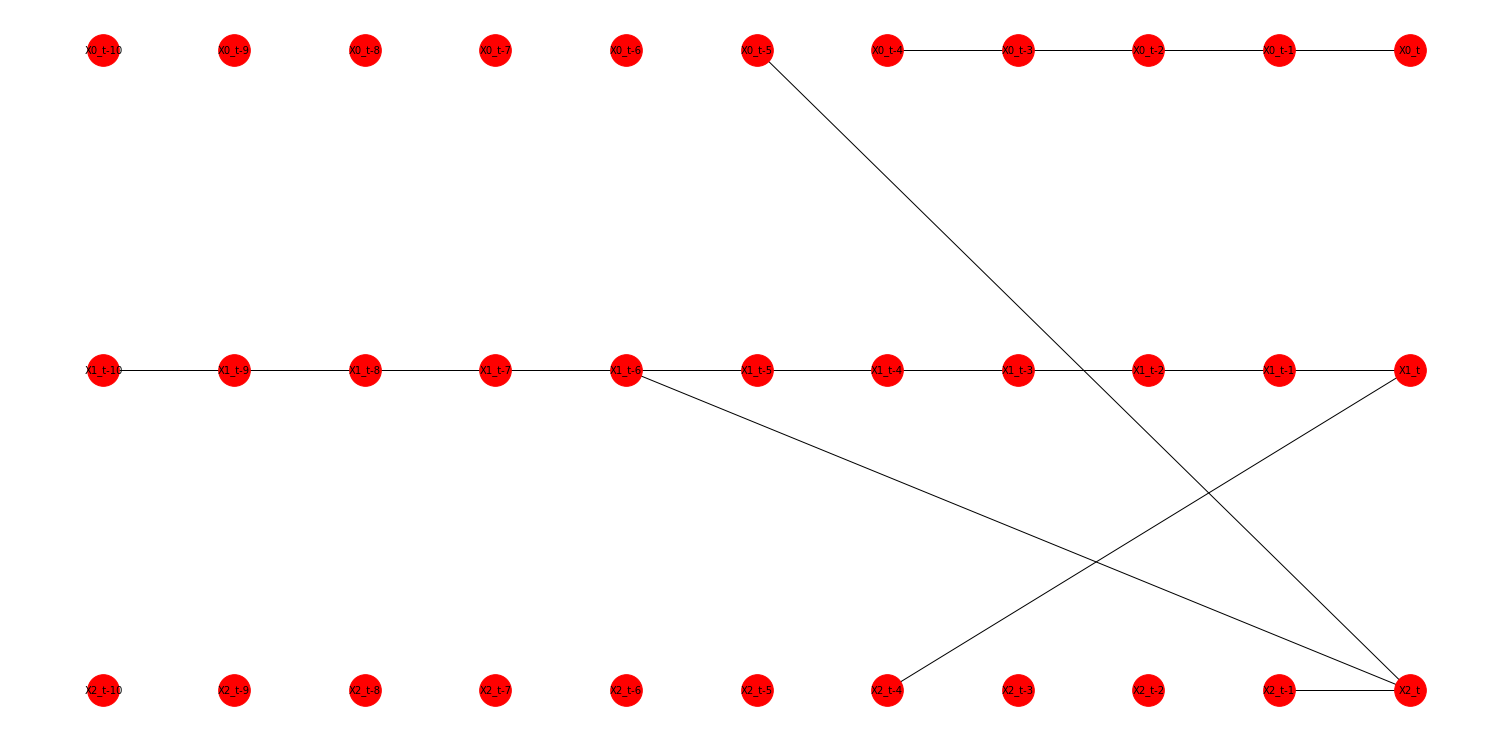

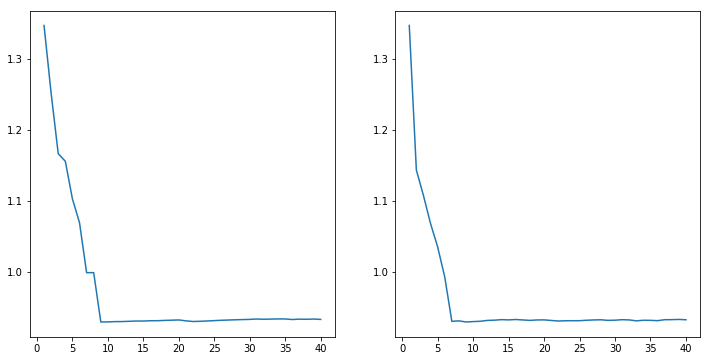

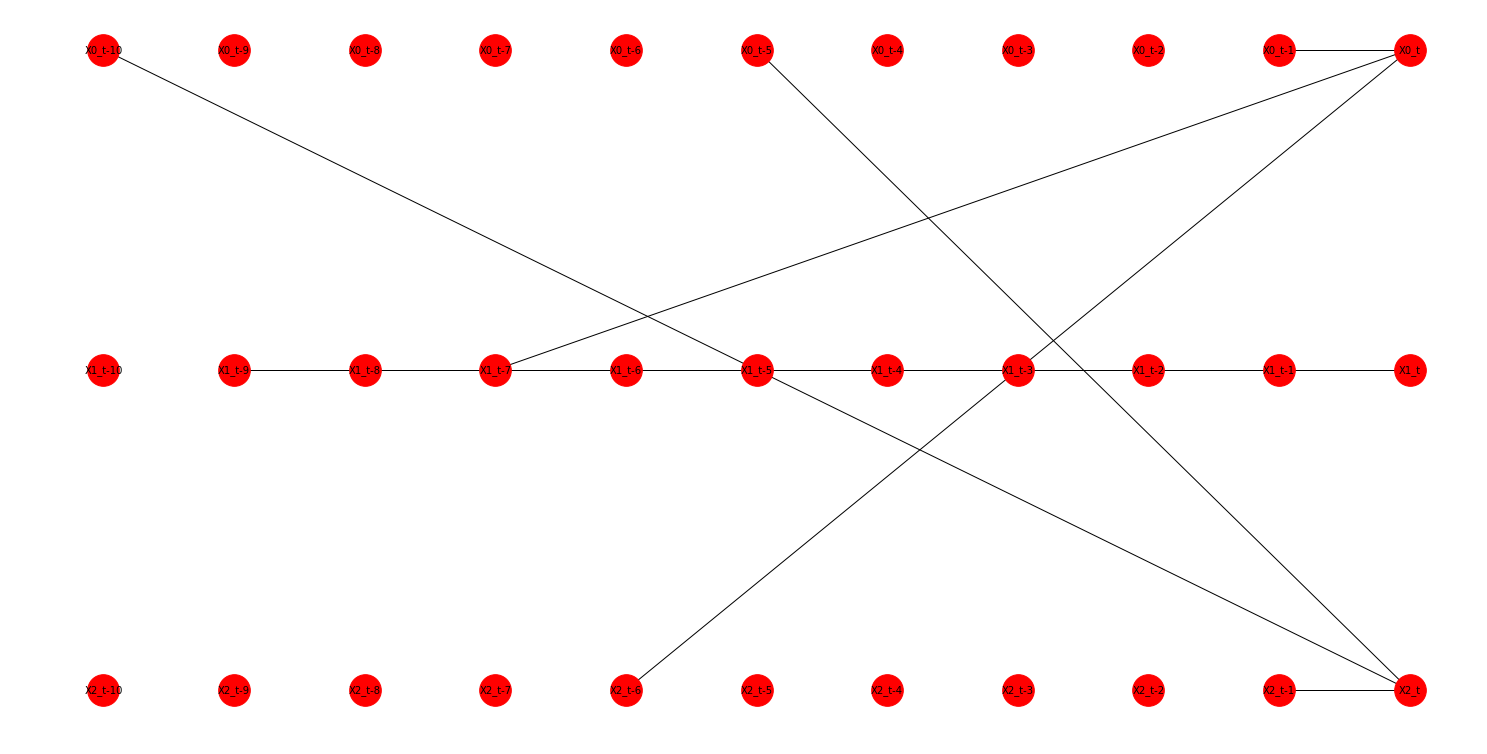

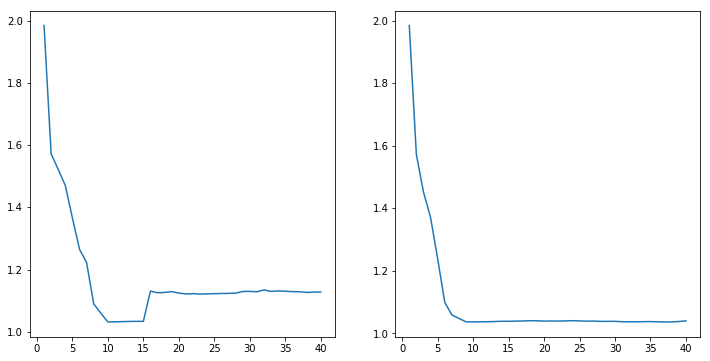

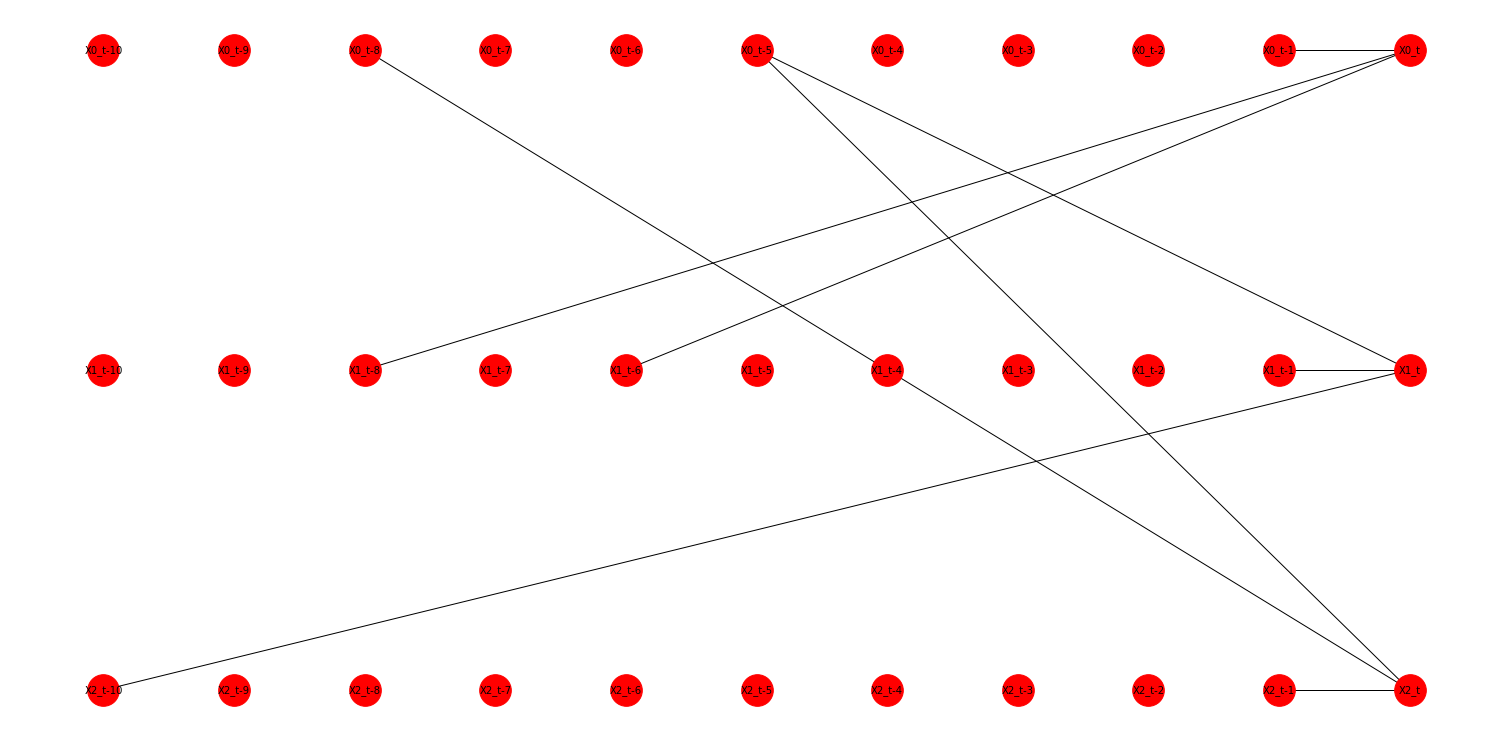

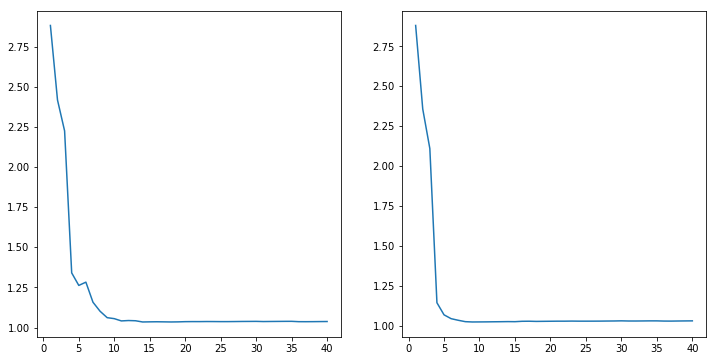

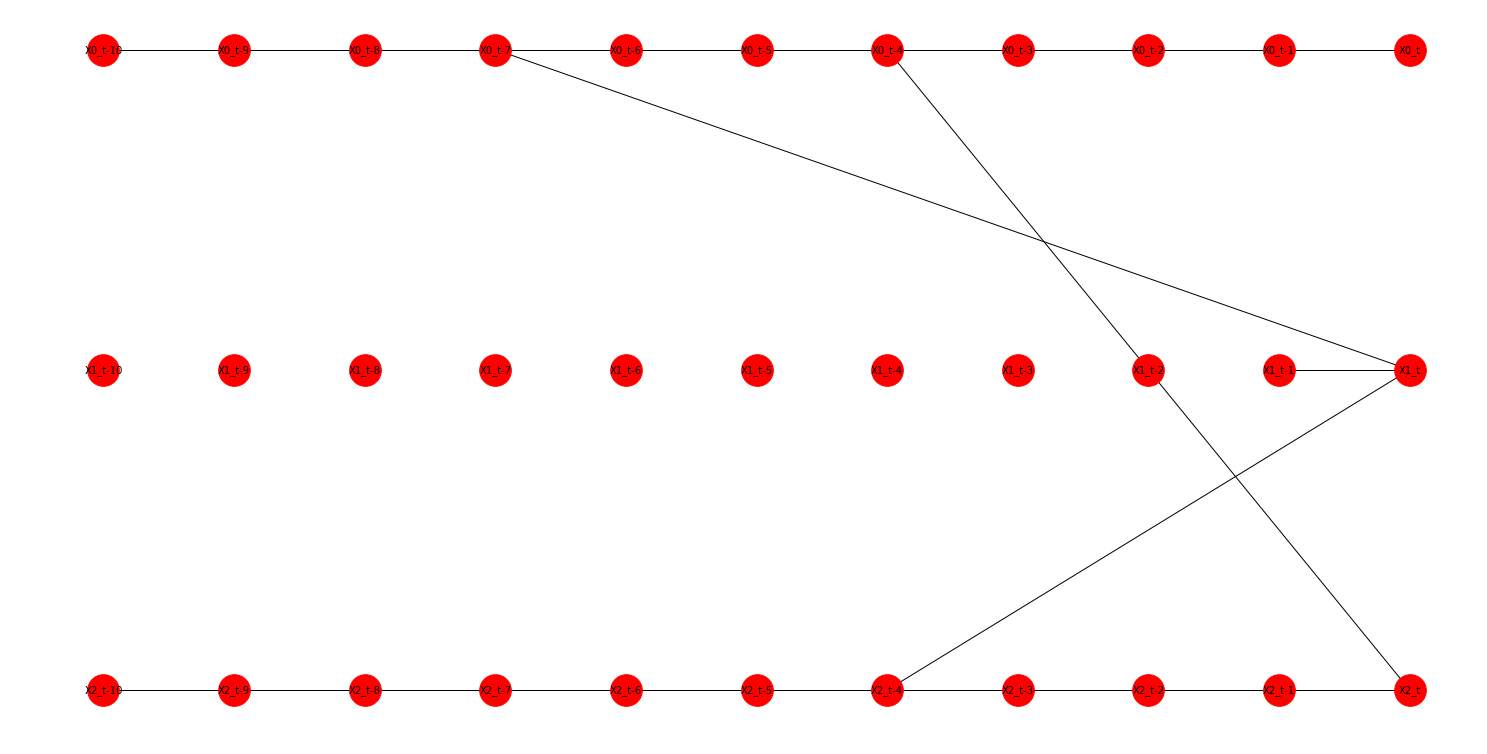

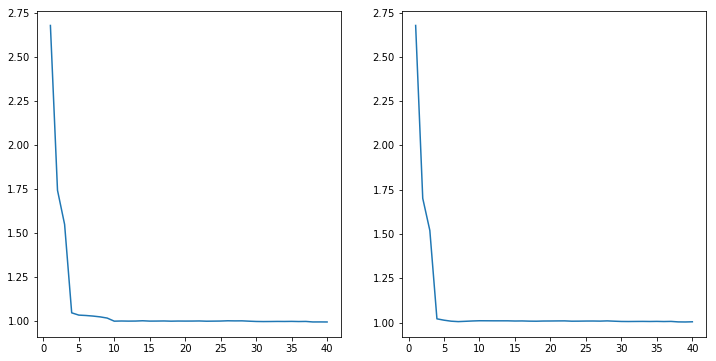

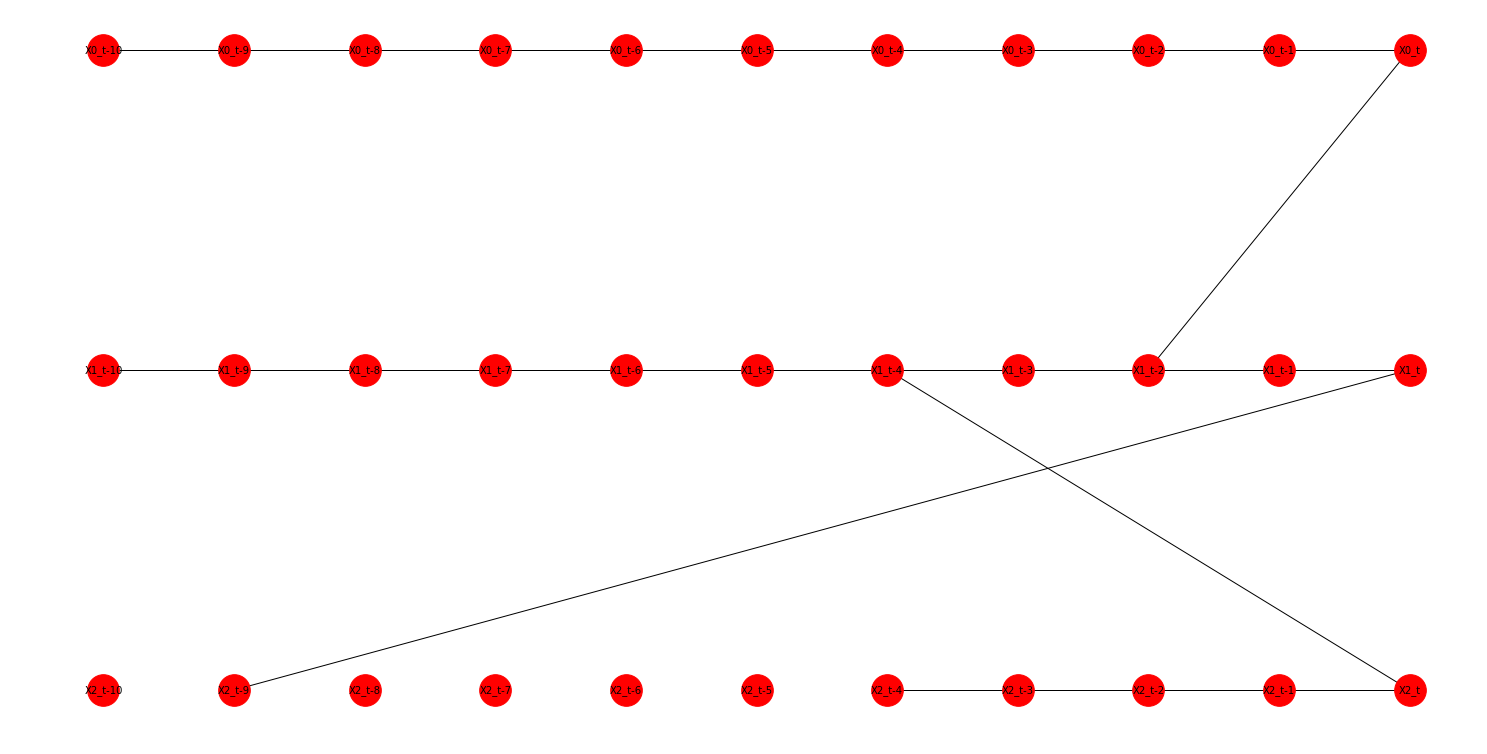

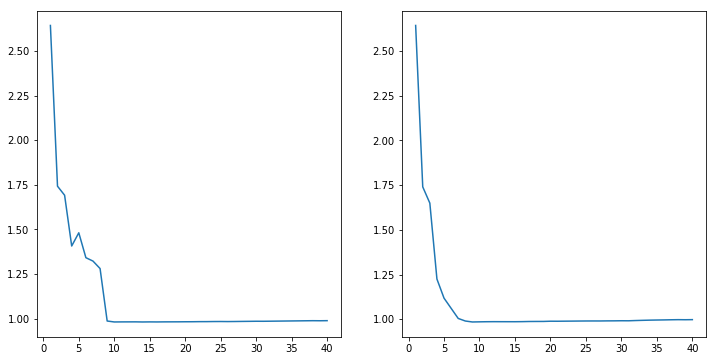

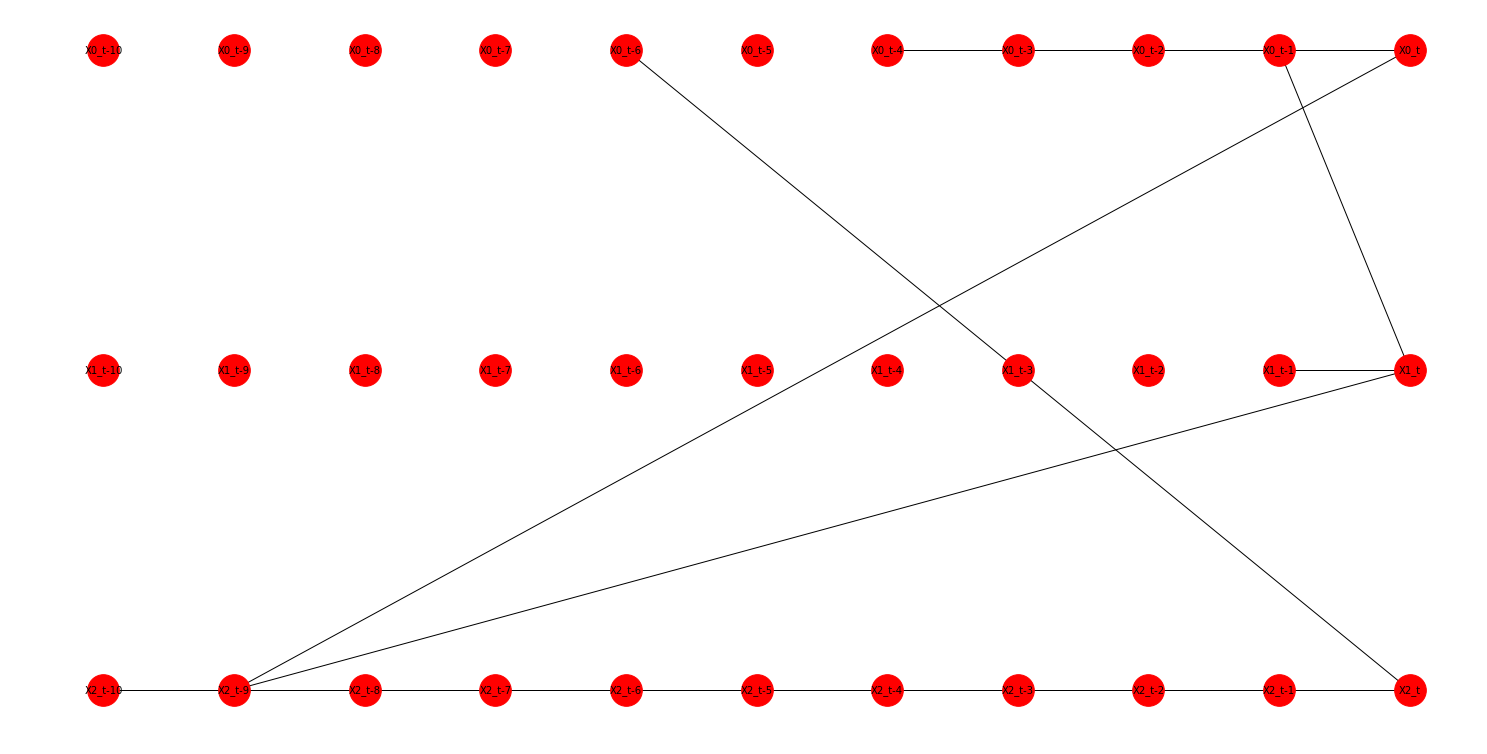

In [14]:
setting = {'dim': 3, 'in_edges': 2, 'p': 10}
for exp, exp_var in zip(select_experiments(setting, results_pc1), select_experiments(setting, results_var)):
    graph = nx.from_dict_of_lists(exp['true_graph'])
    
    plt.figure(figsize=(12, 6))
    
    bics = [iteration['bic'] for iteration in exp['iterations']]
    p_iter = [iteration['p_iter'] for iteration in exp['iterations']]
    
    plt.subplot(1, 2, 1)
    #p_est = simulate_patience(exp['iterations'], 1)['p_est']
    #plt.axvline(p_est, c='r')
    plt.plot(p_iter, bics)
    
    bics_var = [est['test_mse'] for est in exp_var['estimates']]
    p_est_var = [est['p_est'] for est in exp_var['estimates']]
    bics_var = np.array(bics_var)[np.argsort(p_est_var)]
    p_est_var = np.sort(p_est_var)
    
    plt.subplot(1, 2, 2)
    plt.plot(p_est_var, bics_var)
    
    plt.show()
    
    plt.figure(figsize=(20, 10))
    draw_graph(graph, setting['dim'], setting['p'])